   #### Docs for VS Code & Jupyter notebooks [here](https://code.visualstudio.com/docs/python/jupyter-support)
   # Jump to sections of interest:
   1. Visualizing Raw Datasets
     1. [Kowalcyzk et al.](#kowal)
     2. [CellBench](#cellbench)
   2. Alignment Method Experiments Results
     1. [Iterative Closest Point (ICP)](#icp)
     2. [ICP 2](#icp2)
     3. [ScAlign](#scalign)
   3. [LISI Performance Metric](#lisi)

  ### Imports & constants

In [1]:
from collections import defaultdict
from functools import partial
from pathlib import Path
from os import makedirs
from os.path import exists

get_ipython().run_line_magic('matplotlib', 'inline')
import anndata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from IPython import display
import torch
#torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.optim as optim
import mnnpy

from scalign import ScAlign

import icp
import metrics

N_PC = 100
FILTER_MIN_GENES = 1.8e3
FILTER_MIN_READS = 10
FILTER_MIN_DETECTED = 5
DO_STANDARDIZE = False


   # Load datasets, clean them, view reduced dimensions

In [2]:
datasets = {}


   ### Functions for cleaning the data (filtering)

In [3]:
def remove_doublets(df_counts, df_meta):
    df_counts = df_counts.loc[df_meta['demuxlet_cls'] == 'SNG', :]
    df_meta = df_meta.loc[df_meta['demuxlet_cls'] == 'SNG', :]
    return df_counts, df_meta

''' Remove cells which do not have at least min_genes detected genes
'''
def filter_cells(df_counts, df_meta, min_genes):
    cell_idx = df_counts.astype(bool).sum(axis=1) > min_genes
    df_counts = df_counts.loc[cell_idx, :]
    df_meta = df_meta.loc[cell_idx, :]
    return df_counts, df_meta

''' Remove genes that don't have at least min_reads number of reads
'''
def filter_low_read_genes(df, min_reads):
    df = df.loc[:, df.sum(axis=0) > min_reads]
    return df

''' Remove genes that don't have at least min_cells number of detections
'''
def filter_low_detected_genes(df, min_cells):
    df = df.loc[:, df.astype(bool).sum(axis=0) > min_cells]
    return df


def clean_counts(df_counts, df_meta, min_lib_size=FILTER_MIN_GENES, min_reads=FILTER_MIN_READS, min_detected=FILTER_MIN_DETECTED):
    # filter out low-gene cells
    df_counts, df_meta = filter_cells(df_counts, df_meta, min_lib_size)
    # remove genes that don't have many reads
    df_counts = filter_low_read_genes(df_counts, min_reads)
    # remove genes that are not seen in a sufficient number of cells
    df_counts = filter_low_detected_genes(df_counts, min_detected)
    return df_counts, df_meta


  ### Reduce dimensions (PCA, UMAP, t-SNE) & visualize

In [4]:
def embed(datasets, key, do_standardize):
    print('fitting PCA')
    pca_model = PCA(n_components=N_PC).fit(datasets[key].X)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
    ax1.set_ylabel('explained variance')
    ax1.set_xlabel('PC')
    ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
    ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('cumulative explained variance')
    #fig.show()

    if do_standardize:
        # standardize the data for the PCA reduced dimensions (prior to fitting PCA)
        datasets[key].X = StandardScaler().fit_transform(datasets[key].X)
        print('fitting PCA (Standardized)')
        pca_model = PCA(n_components=N_PC).fit(datasets[key].X)
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
        ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
        ax1.set_ylabel('explained variance')
        ax1.set_xlabel('PC')
        ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
        ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
        ax2.set_xlabel('number of components')
        ax2.set_ylabel('cumulative explained variance')
    datasets[key].obsm['PCA'] = pca_model.transform(datasets[key].X)
    # # Data standardizer for when using PCA
    # datasets[key].uns['PCA-Standard-Scaler'] = StandardScaler.fit(datasets[key].obsm['PCA'])
    print('fitting UMAP')
    datasets[key].obsm['UMAP'] = umap.UMAP().fit_transform(datasets[key].X)
    print('fitting tSNE')
    datasets[key].obsm['TSNE'] = TSNE(n_components=2).fit_transform(datasets[key].obsm['PCA'])

def visualize(datasets, ds_key, cell_type_key='cell_type', batch_key='batch'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
    fig.suptitle('Embeddings of Original {} Data'.format(ds_key))
    ax1.set_title('PCA')
    ax2.set_title('t-SNE')
    ax3.set_title('UMAP')
    num_batches = len(np.unique(datasets[ds_key].obs[batch_key]))
    opacities = [0.6, 0.2, 0.2][:num_batches]
    markers = ['o', 'o', 'P'][-num_batches:]
    for cell_type, shade in zip(np.unique(datasets[ds_key].obs[cell_type_key]), ['m', 'g', 'c']):
        for batch, opacity, marker in zip(np.unique(datasets[ds_key].obs[batch_key]), opacities, markers):
            idx = np.where((datasets[ds_key].obs[cell_type_key] == cell_type) & (datasets[ds_key].obs[batch_key] == batch))[0]
            for embedding_key, ax in zip(['PCA', 'UMAP', 'TSNE'], [ax1, ax2, ax3]):
                X_subset = datasets[ds_key].obsm[embedding_key][idx, :2]
                ax.scatter(X_subset[:,0], X_subset[:,1], s=20, c=shade, edgecolors='none', marker=marker, alpha=opacity, label='{}_{}'.format(cell_type, batch))
    plt.legend(markerscale=3., loc="upper left", bbox_to_anchor=(1,1))
    plt.subplots_adjust(right=0.85)
    plt.savefig('{}_embeddings.pdf'.format(ds_key), bbox='tight')
    plt.show


   ## Dataset: Kowalcyzk et al.

In [5]:
# Load and clean
counts = pd.read_csv('data/Kowalcyzk/Kowalcyzk_counts.csv', index_col=0).T
meta = pd.read_csv('data/Kowalcyzk/Kowalcyzk_meta.csv', index_col=0)
counts, meta = clean_counts(counts, meta)
adata = anndata.AnnData(X=counts.values, obs=meta)
print(adata.X.shape)
print(adata.obs.info())
datasets['Kowalcyzk'] = adata



(1022, 8354)
<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, young_LT_HSC_2 to old_MPP_180
Data columns (total 2 columns):
cell_age     1022 non-null object
cell_type    1022 non-null object
dtypes: object(2)
memory usage: 64.0+ KB
None


fitting PCA
fitting UMAP
fitting tSNE


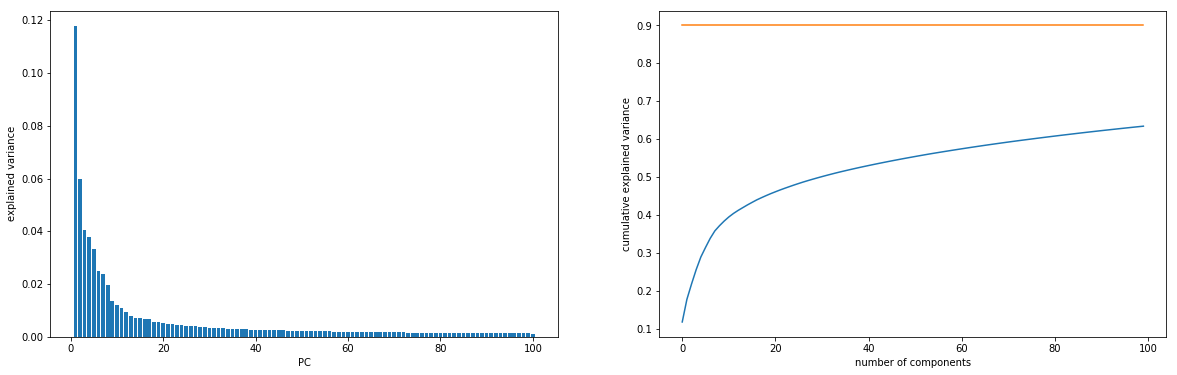

In [6]:
# Reduce dims
embed(datasets, 'Kowalcyzk', do_standardize=DO_STANDARDIZE)


  <a name="kowal"></a>
  ### Kowalcyzk Visualizations

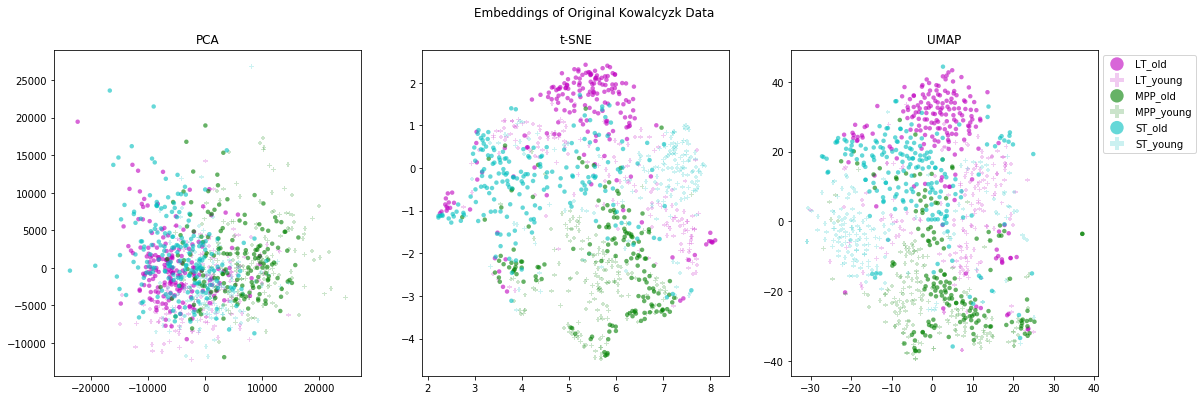

In [7]:
# Visualize
visualize(datasets, 'Kowalcyzk', cell_type_key='cell_type', batch_key='cell_age')


  ## Dataset: Mann et al.

   ## Dataset: CellBench

In [8]:
# Load and clean
protocols = ['10x', 'CELseq2', 'Dropseq']
adatas = []
for protocol in protocols:
    print(protocol)
    counts = pd.read_csv('data/CellBench/{}_counts.csv'.format(protocol), index_col=0).T
    counts = counts.loc[:, ~counts.columns.duplicated()]
    #counts.drop_duplicates(inplace=True)
    meta = pd.read_csv('data/CellBench/{}_meta.csv'.format(protocol), index_col=0)
    counts, meta = remove_doublets(counts, meta)
    counts, meta = clean_counts(counts, meta)
    adatas.append(anndata.AnnData(X=counts.values, obs=meta, var=pd.DataFrame(index=counts.columns)))
    print(adatas[-1].shape)
    #print(adatas[-1].var)
datasets['CellBench'] = anndata.AnnData.concatenate(*adatas, join='inner', batch_key='protocol', batch_categories=protocols)
print('Merged shape: {}'.format(datasets['CellBench'].shape))



10x
(895, 16241)
CELseq2
(240, 16876)
Dropseq
(210, 13987)
Merged shape: (1345, 12829)


fitting PCA
fitting UMAP
fitting tSNE


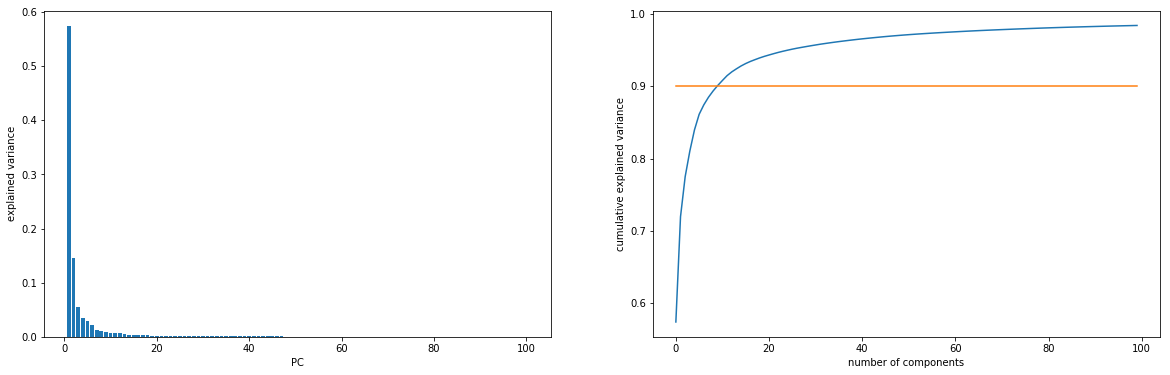

In [9]:
# Reduce dims
embed(datasets, 'CellBench', do_standardize=DO_STANDARDIZE)


  <a name="cellbench"></a>
  ### CellBench Visualizations

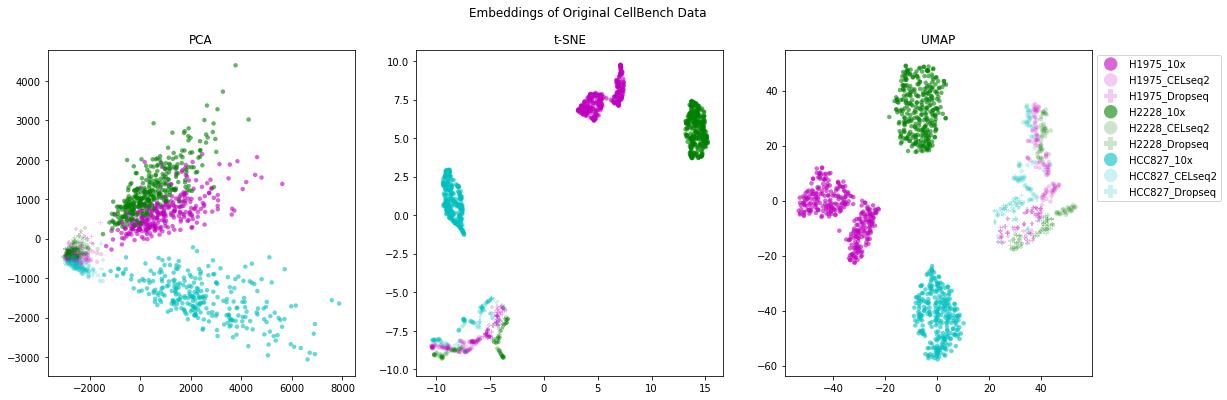

In [10]:
# Visualize
visualize(datasets, 'CellBench', cell_type_key='cell_line_demuxlet', batch_key='protocol')


  ### Functions to prepare data for input to alignment methods, visualize alignments, score alignments

In [11]:
def get_source_target(datasets, ds_key, batch_key, cell_type_key, source_name, target_name, use_PCA=False, leave_out_type=None):
    source_idx = datasets[ds_key].obs[batch_key] == source_name
    if leave_out_type is not None:
        target_idx = (datasets[ds_key].obs[batch_key] == target_name) & (datasets[ds_key].obs[cell_type_key] != leave_out_type)
    else:
        target_idx = datasets[ds_key].obs[batch_key] == target_name
    if use_PCA:
        source = datasets[ds_key].obsm['PCA'][source_idx]
        target = datasets[ds_key].obsm['PCA'][target_idx]
    else:
        source = datasets[ds_key].X[source_idx]
        target = datasets[ds_key].X[target_idx]
    type_index_dict = {}
    combined_types = np.concatenate((datasets[ds_key].obs[cell_type_key][source_idx],
                                     datasets[ds_key].obs[cell_type_key][target_idx]))
    for cell_type in np.unique(combined_types):
        type_index_dict[cell_type] = np.where(combined_types == cell_type)[0]
    subset_meta = pd.concat((datasets[ds_key].obs[source_idx], datasets[ds_key].obs[target_idx]), axis=0)
    return source, target, type_index_dict, subset_meta



def before_and_after_plots(A, B, type_index_dict, aligner_fcn, standardize=True, do_B_transform=False):
    fig, axes = plt.subplots(2, 2, figsize=(20,20))
    # Before alignment
    if standardize:
        scaler = StandardScaler().fit(np.concatenate((A, B)))
        A = scaler.transform(A)
        B = scaler.transform(B)
    A_size = A.shape[0]
    combined = TSNE(n_components=2).fit_transform(np.concatenate((A, B)))
    axes[0,0].scatter(combined[:A_size,0], combined[:A_size,1], c='m', label='source', alpha=0.15)
    axes[0,0].scatter(combined[A_size:,0], combined[A_size:,1], c='b', label='target', alpha=0.15)
    axes[0,0].legend()
    axes[0,0].set_title('t-SNE (before)')
    for cell_type, idx in type_index_dict.items():
        axes[0,1].scatter(combined[idx, 0], combined[idx, 1], label=cell_type, alpha=0.15)
        axes[0,1].legend()
    # Aligned
    A = aligner_fcn(A)
    if do_B_transform:
        B = aligner_fcn(B)
    combined = TSNE(n_components=2).fit_transform(np.concatenate((A, B)))
    axes[1,0].scatter(combined[:A_size,0], combined[:A_size,1], c='m', label='source', alpha=0.15)
    axes[1,0].scatter(combined[A_size:,0], combined[A_size:,1], c='b', label='target', alpha=0.15)
    axes[1,0].legend()
    axes[1,0].set_title('t-SNE (after)')
    for cell_type, idx in type_index_dict.items():
        axes[1,1].scatter(combined[idx, 0], combined[idx, 1], label=cell_type, alpha=0.15)
        axes[1,1].legend()

def compute_lisi(A, B, combined_meta, batch_key, cell_type_key, aligner_fcn, perplexity=30, do_B_transform=False):
    A = aligner_fcn(A)
    if do_B_transform:
        B = aligner_fcn(B)
    X = np.concatenate((A, B))
    print(X.shape)
    assert(X.shape[0] == combined_meta.shape[0])
    return metrics.lisi2(X, combined_meta, [batch_key, cell_type_key], perplexity=perplexity)



In [0]:
def plot_lisi(lisi_dfs, method_names, alignment_task, fig, figure_grid, i, j):
    sub_grid = figure_grid[i,j].subgridspec(1, 2, wspace=0.9)
    ilisi_ax = plt.Subplot(fig, sub_grid[0])
    ilisi_ax.set_title('Dataset mixing')
    lisi_data = [df[alignment_task.batch_key].values for df in lisi_dfs]
    ilisi_ax.boxplot(lisi_data, vert=False, labels=method_names, showfliers=False)
    ilisi_ax.set_xlabel('iLISI')
    fig.add_subplot(ilisi_ax)
    
    clisi_ax = plt.Subplot(fig, sub_grid[1])
    clisi_ax.set_title('Cell-type mixing')
    lisi_data = [df[alignment_task.ct_key] for df in lisi_dfs]
    clisi_ax.boxplot(lisi_data, vert=False, labels=method_names, showfliers=False)
    clisi_ax.set_xlabel('cLISI')
    fig.add_subplot(clisi_ax)

# Plotting function to visualize each alignment task result
def plot_embedding(adata, embed_key, alignment_task, fig, figure_grid, i, j, standardize=True):
#     if standardize:
#         scaler = StandardScaler().fit(adata.obsm[embed_key])
#         new_embed_key = embed_key + '_std'
#         adata.obsm[new_embed_key] = scaler.transform(adata.obsm[embed_key])
#         embed_key = new_embed_key
    sub_grid = figure_grid[i,j].subgridspec(1, 2)
    batch_ax = plt.Subplot(fig, sub_grid[0])
    batch_ax.set_xticks([])
    batch_ax.set_yticks([])
    batch_colors = ['m', 'c']
    for batch, color in zip(np.unique(adata.obs[alignment_task.batch_key]), batch_colors):
        idx = np.where(adata.obs[alignment_task.batch_key] == batch)[0]
        batch_ax.scatter(adata.obsm[embed_key][idx, 0], adata.obsm[embed_key][idx, 1], c=color, label=batch, alpha=0.15)
    fig.add_subplot(batch_ax)
    
    ct_ax = plt.Subplot(fig, sub_grid[1])
    ct_ax.set_xticks([])
    ct_ax.set_yticks([])
    for ct in np.unique(adata.obs[alignment_task.ct_key]):
        idx = np.where(adata.obs[alignment_task.ct_key] == ct)[0]
        ct_ax.scatter(adata.obsm[embed_key][idx, 0], adata.obsm[embed_key][idx, 1], label=ct, alpha=0.15)
    fig.add_subplot(ct_ax)
    
# Select Alignment tasks
class AlignmentTask(object):
    def __init__(self, ds_key, batch_key, ct_key, source_batch, target_batch, leave_out_ct=None):
        self.ds_key = ds_key # dataset key
        self.batch_key = batch_key
        self.ct_key = ct_key # cell type key
        self.source_batch = source_batch
        self.target_batch = target_batch
        self.leave_out_ct = leave_out_ct
    
    def as_title(self):
        if self.leave_out_ct is not None:
            return '{}:\n{}->{}\n(\\{})'.format(self.ds_key, self.source_batch, self.target_batch, self.leave_out_ct)
        else:
            return '{}:\n{}->{}'.format(self.ds_key, self.source_batch, self.target_batch)
        
    def __str__(self):
        return self.as_title().replace('\n', '')

alignment_tasks = []
alignment_tasks.append(AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2'))
alignment_tasks.append(AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', 'H1975'))
alignment_tasks.append(AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', 'H2228'))
alignment_tasks.append(AlignmentTask('Kowalcyzk', 'cell_age', 'cell_type', 'young', 'old'))
for task in alignment_tasks:
    print(task)
# Select alignment methods:
#methods = [None, 'MNN']
#methods = ['None', 'ICP', 'ICP2', 'ICP2_act+lin', 'ICP2_xentropy', 'ScAlign', 'MNN']
methods = ['None', 'ICP2_xentropy']
#methods = [None, 'ScAlign']
#methods = [None, 'MNN']

plot_scaler = 5
fig = plt.figure(figsize=(plot_scaler*len(alignment_tasks), plot_scaler*len(methods)), constrained_layout=False)
outer_grid = fig.add_gridspec(len(methods) + 1, len(alignment_tasks) + 1)

pca_fig = plt.figure(figsize=(plot_scaler*len(alignment_tasks), plot_scaler*len(methods)), constrained_layout=False)
pca_outer_grid = pca_fig.add_gridspec(len(methods) + 1, len(alignment_tasks) + 1, wspace=0.25)

lisi_fig = plt.figure(figsize=(plot_scaler*len(alignment_tasks), plot_scaler), constrained_layout=False)
lisi_outer_grid = lisi_fig.add_gridspec(2, len(alignment_tasks))

for i, task in enumerate(alignment_tasks):
    ax = fig.add_subplot(outer_grid[0, i + 1])
    ax.text(0.5, 0.2, task.as_title(), va="top", ha="center")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = pca_fig.add_subplot(pca_outer_grid[0, i + 1])
    ax.text(0.5, 0.2, task.as_title(), va="top", ha="center")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = lisi_fig.add_subplot(lisi_outer_grid[0, i])
    ax.text(0.5, 0.3, task.as_title(), va="top", ha="center")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, method in enumerate(methods):
    ax = fig.add_subplot(outer_grid[i+1, 0])
    if method is None:
        method = 'none'
    ax.text(0.7, 0.5, method, va="center", ha="left")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = pca_fig.add_subplot(pca_outer_grid[i+1, 0])
    if method is None:
        method = 'none'
    ax.text(0.7, 0.5, method, va="center", ha="left")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for j, task in enumerate(alignment_tasks):
    print(task)
    if task.leave_out_ct is not None:
        task_idx = (datasets[task.ds_key].obs[task.batch_key] == task.source_batch) | ((datasets[task.ds_key].obs[task.batch_key] == task.target_batch) & (datasets[task.ds_key].obs[task.ct_key] != task.leave_out_ct))
    else:
        task_idx = (datasets[task.ds_key].obs[task.batch_key] == task.source_batch) | (datasets[task.ds_key].obs[task.batch_key] == task.target_batch)
    task_adata = datasets[task.ds_key][task_idx]
    
    lisi_scores = []
    
    for i, method in enumerate(methods):
        print('\t{}'.format(method))
        method_key = '{}_aligned'.format(method)
        if method == 'None':
            plot_embedding(task_adata, 'TSNE', task, fig, outer_grid, i+1, j+1)
            plot_embedding(task_adata, 'PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm['PCA'], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'ICP' or method == 'ICP2' or method=='ICP2_act' or method == 'ICP2_act+lin' or method == 'ICP2_xentropy':
            A, B, type_index_dict, combined_meta = get_source_target(datasets, task.ds_key,
                                                                     task.batch_key, task.ct_key, 
                                                                     task.source_batch, task.target_batch,
                                                                     use_PCA=True, leave_out_type=task.leave_out_ct)
            print(A.shape)
            print(B.shape)
            if method == 'ICP':
                aligner = icp.ICP(A, B, type_index_dict, loss_function=icp.closest_point_loss, max_iters=200, verbose=False)
            elif method == 'ICP2':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
                aligner = icp.ICP(A, B, type_index_dict, loss_function=loss_fcn, max_iters=200, verbose=False)
            elif method == 'ICP2_act':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
                aligner = icp.ICP(A, B, type_index_dict, act='tanh', loss_function=loss_fcn, max_iters=200, verbose=False)
            elif method == 'ICP2_act+lin':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
                aligner = icp.ICP(A, B, type_index_dict, n_layers=2, act='tanh', loss_function=loss_fcn, max_iters=200, verbose=False)
            elif method == 'ICP2_xentropy':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)# ignored
                aligner = icp.ICP(A, B, type_index_dict, loss_function=loss_fcn, max_iters=200, verbose=False, use_xentropy_loss=True)
            aligner_fcn = lambda x: aligner(torch.from_numpy(x).float()).detach().numpy()
            #standardizing because it was fitted with standardized data (see ICP code)
            scaler = StandardScaler().fit(np.concatenate((A,B)))
            A = scaler.transform(A)
            B = scaler.transform(B)
            A = aligner_fcn(A)
            print(A.shape)
            n_samples = task_adata.shape[0]
            n_dims = A.shape[1]
            task_adata.obsm[method_key] = np.zeros((n_samples, n_dims))
            a_idx = np.where(task_adata.obs[task.batch_key] == task.source_batch)[0]
            b_idx = np.where(task_adata.obs[task.batch_key] == task.target_batch)[0]
            task_adata.obsm[method_key][a_idx, :] = A
            task_adata.obsm[method_key][b_idx, :] = B
            #lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30)
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            plot_embedding(task_adata, method_key+'_TSNE', task, fig, outer_grid, i+1, j+1)
            plot_embedding(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'ScAlign':
            #idx = (datasets['CellBench'].obs['cell_line_demuxlet'] == 'H2228') & (datasets['CellBench'].obs['protocol'] == 'CELseq2')
            #datasets['CellBench'] = datasets['CellBench'][ ~idx ,:]
            sc_align = ScAlign(
                object1_name=task.source_batch,
                object2_name=task.target_batch, 
                object_var=task.batch_key,
                label_var=task.ct_key,
                data_use='PCA',
                user_options={
                    #'max_steps': 100,
                    'logdir': 'scAlign_model',
                    'log_results': True,
                    'early_stop': True
                },
                device='CPU')
            sc_align.fit_encoder(task_adata)
            print('Trained encoder saved to: {}'.format(sc_align.trained_encoder_path_))
            task_adata.obsm[method_key] = sc_align.encode(task_adata.obsm['PCA'])
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            plot_embedding(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            plot_embedding(task_adata, method_key+'_TSNE', task, fig, outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'MNN':
            A_idx = task_adata.obs[task.batch_key] == task.source_batch
            B_idx = task_adata.obs[task.batch_key] == task.target_batch
            A_X = task_adata[A_idx].obsm['PCA']
            B_X = task_adata[B_idx].obsm['PCA']
#             # standardizing
#             scaler = StandardScaler().fit(np.concatenate((A_X,B_X)))
#             A_X = scaler.transform(A_X)
#             B_X = scaler.transform(B_X)
            mnn_adata_A = anndata.AnnData(X=A_X, obs=task_adata[A_idx].obs)
            mnn_adata_B = anndata.AnnData(X=B_X, obs=task_adata[B_idx].obs)
            corrected = mnnpy.mnn_correct(mnn_adata_A, mnn_adata_B)
            task_adata.obsm[method_key] = np.zeros(corrected[0].shape)
            task_adata.obsm[method_key][np.where(A_idx)[0]] = corrected[0].X[:mnn_adata_A.shape[0]]
            task_adata.obsm[method_key][np.where(B_idx)[0]] = corrected[0].X[mnn_adata_A.shape[0]:]
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            plot_embedding(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            plot_embedding(task_adata, method_key+'_TSNE', task, fig, outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
    plot_lisi(lisi_scores, methods, task, lisi_fig, lisi_outer_grid, 1, j)
fig.savefig('comparison_tsne.pdf')
fig.savefig('comparison_tsne.png')
pca_fig.savefig('comparison_tsne.pdf')
pca_fig.savefig('comparison_tsne.png')
lisi_fig.savefig('comparison_scores.pdf')
lisi_fig.savefig('comparison_scores.png')
            
# all_axes = fig.get_axes()
# print(len(all_axes))
# for ax in all_axes:
#     if ax.is_first_row():
#         ax.set_title('foo')
#outer_grid[0,0].get_axes()


 # Testing ICP Xentropy

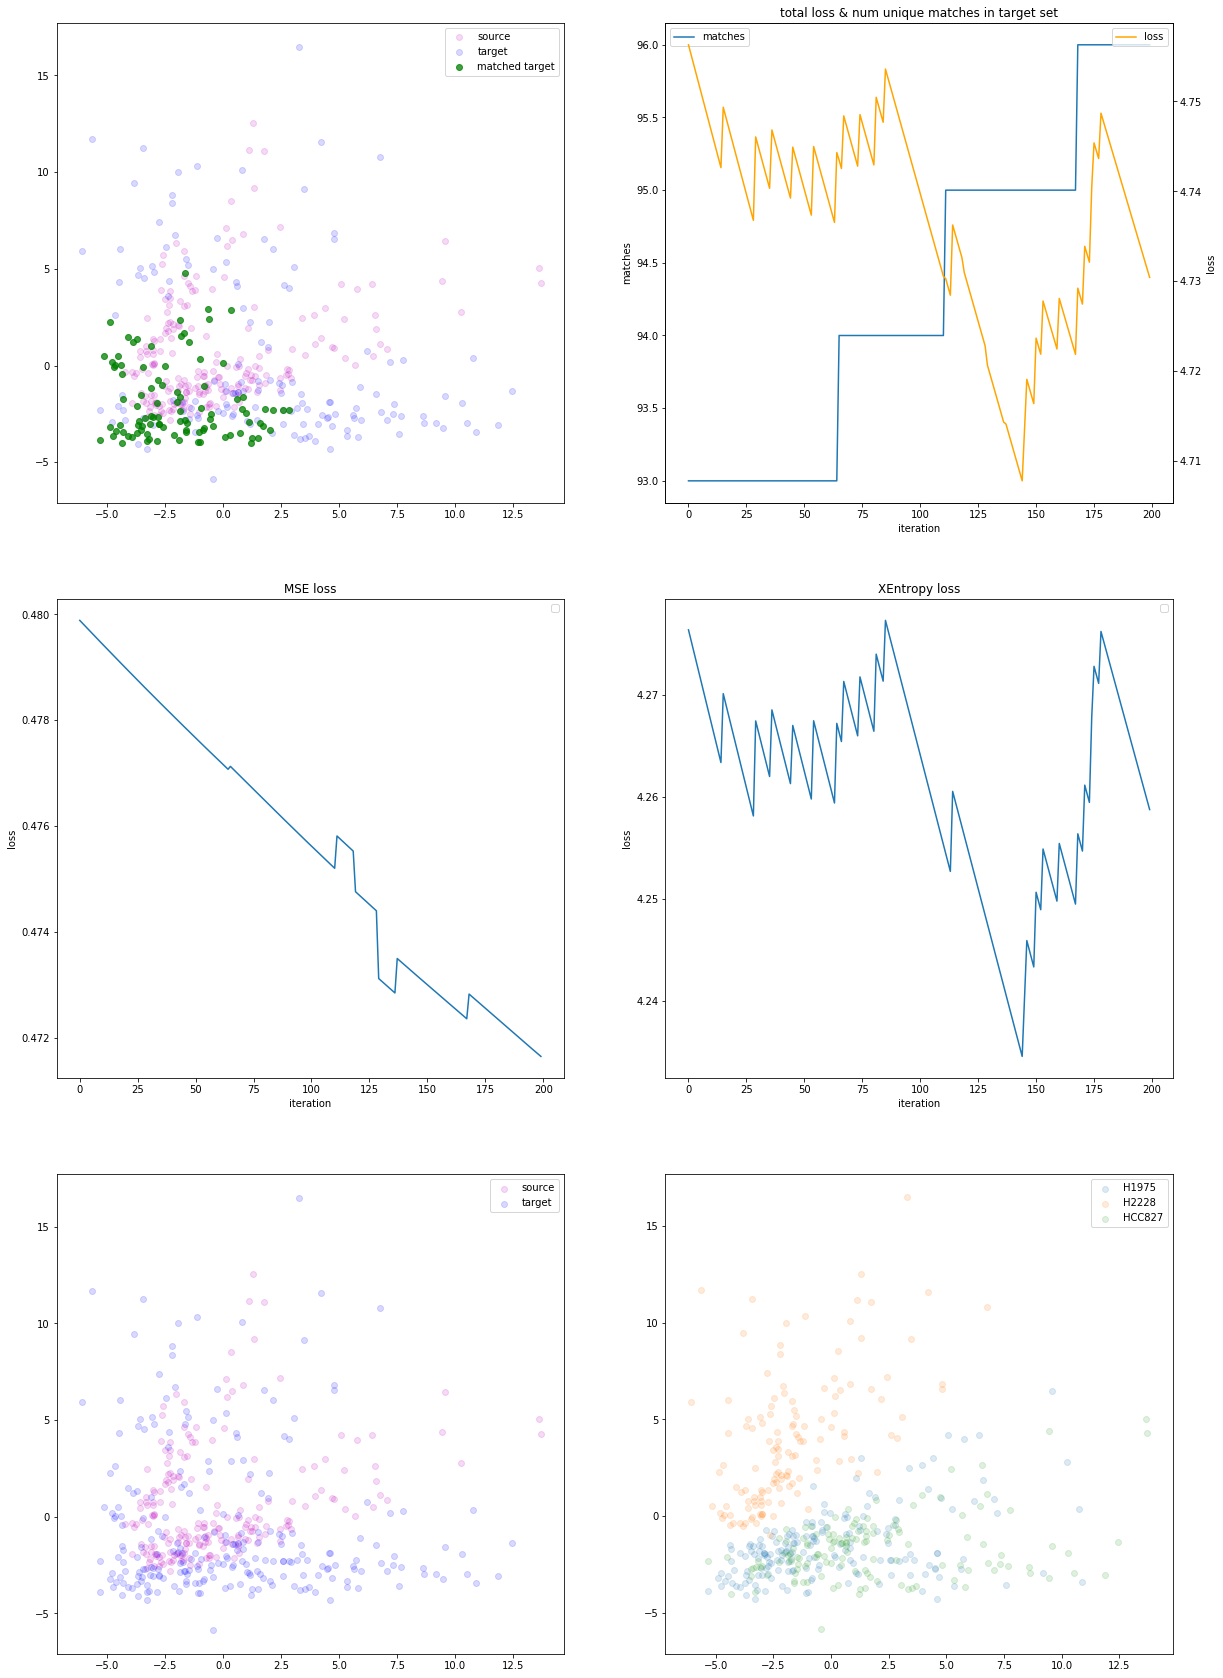

In [12]:
# Get source and target data
A, B, type_index_dict, combined_meta = get_source_target(datasets, 'CellBench',
                                                         'protocol', 'cell_line_demuxlet', 
                                                        'Dropseq', 'CELseq2',
                                                         use_PCA=True)
print(A.shape)
print(B.shape)
loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
log_dir = 'xentropy_test'
if not exists(log_dir):
    makedirs(xentropy)
aligner = icp.ICP(A, B, type_index_dict, loss_function=loss_fcn, max_iters=200, verbose=True, use_xentropy_loss=True)

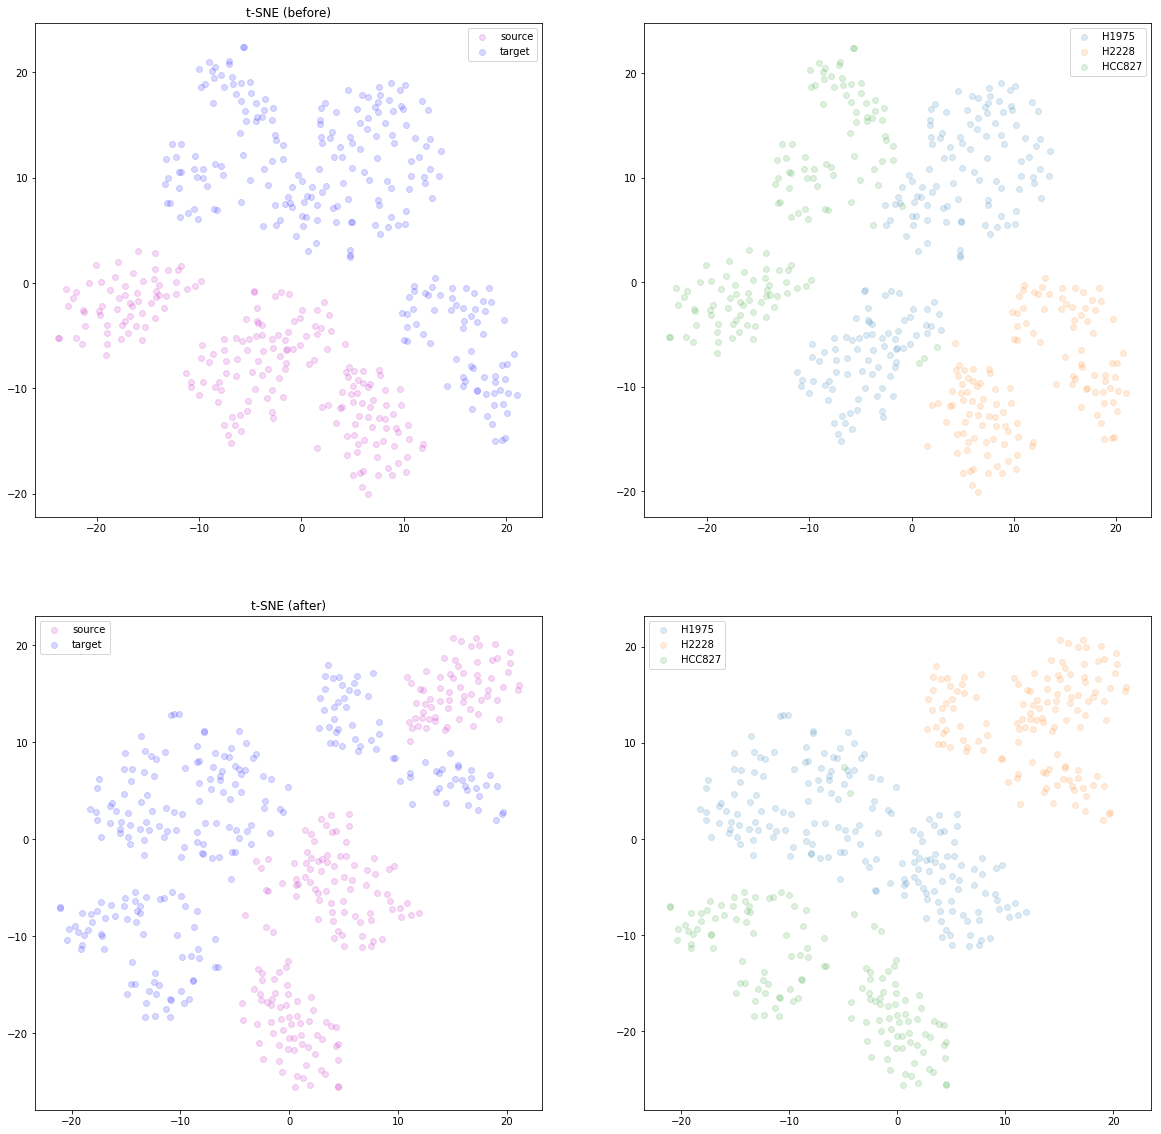

In [15]:
aligner_fcn=lambda x: aligner(torch.from_numpy(x).float()).detach().numpy()
before_and_after_plots(A, B, type_index_dict, aligner_fcn=aligner_fcn)